In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import torch
import numpy as np
from pathlib import Path
from scipy import signal
from scipy.fft import fft, fftfreq
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append('../icmplus-hdf5-reader')
from icmh5_reader import SignalProcessor as sp
from train_test_aiden import train, posttrain, WandbLogger, evaluate
from models.model_zoo import VAE
from rich import print as rprint

In [ ]:
def instance_normalize(x, eps=1e-8):
    """
    Perform instance-level z-score normalization on input array.
    Works with shapes (N, 1, 1200) or (N, 1200)
    
    Parameters:
    -----------
    x : numpy.ndarray
        Input array of shape (N, 1, 1200) or (N, 1200)
    eps : float
        Small constant to avoid division by zero
        
    Returns:
    --------
    normalized : numpy.ndarray
        Normalized array with same shape as input
    means : numpy.ndarray
        Mean values for each instance (shape: (N,))
    stds : numpy.ndarray
        Standard deviation values for each instance (shape: (N,))
    """
    
    # Handle different input shapes
    orig_shape = x.shape
    if len(x.shape) == 3:  # (N, 1, 1200)
        x = x.squeeze(1)   # Convert to (N, 1200)
        
    # Calculate mean and std for each instance
    means = np.mean(x, axis=1)  # Shape: (N,)
    stds = np.std(x, axis=1)    # Shape: (N,)
    
    # Reshape means and stds for broadcasting
    means = means[:, np.newaxis]  # Shape: (N, 1)
    stds = stds[:, np.newaxis]    # Shape: (N, 1)
    
    # Perform z-score normalization
    normalized = (x - means) / (stds + eps)
    
    # Restore original shape if necessary
    if len(orig_shape) == 3:
        normalized = normalized[:, np.newaxis, :]
        
    return normalized

def extract_continuous_segments(segs, segment_length=1200):
    """
    Extract non-overlapping continuous segments of specified length from a list of segments,
    excluding any segments containing NaN values.
    
    Parameters:
    -----------
    segs : list
        List of segment objects, where each segment has a .values attribute
    segment_length : int, default=1200
        Length of segments to extract
        
    Returns:
    --------
    np.ndarray
        2D array containing all valid segments, shape (n_segments, segment_length)
    """
    all_segments = []
    
    for seg in segs:
        values = seg.values
        
        # Skip if segment is too short
        if values.shape[0] < 5 * segment_length:
            continue
        
        # Calculate number of complete segments
        n_segments = values.shape[0] // segment_length
        
        # Reshape into segments of length 1200
        segments = values[:n_segments * segment_length].reshape(-1, segment_length)
        
        # Check for NaN in each segment
        valid_mask = ~np.isnan(segments).any(axis=1)
        valid_segments = segments[valid_mask]
        
        all_segments.append(valid_segments)
        print(f"Added {len(valid_segments)} segments")
    
    # Combine all segments
    if all_segments:
        result = np.vstack(all_segments)
    else:
        result = np.array([])
    
    return result

def filter_icp_signals(signals, sampling_rate=120):
    """
    Filter ICP signals based on physiological thresholds, amplitude, and spectral properties.
    
    Parameters:
    -----------
    signals : np.ndarray
        Array of shape (N, 1200) containing ICP signals
    sampling_rate : int, default=120
        Sampling rate of the signals in Hz
    
    Returns:
    --------
    np.ndarray
        Boolean mask indicating valid signals
    """
    valid_mask = np.ones(len(signals), dtype=bool)
    
    # 1. Threshold check (-30 to 200 mmHg)
    threshold_mask = np.logical_and(
        signals >= -30,
        signals <= 200
    ).all(axis=1)
    valid_mask &= threshold_mask
    
    return valid_mask

def apply_icp_filter(signals, sampling_rate=120):
    """
    Apply the ICP filter and return the filtered signals.
    
    Parameters:
    -----------
    signals : np.ndarray
        Array of shape (N, 1200) containing ICP signals
    sampling_rate : int, default=120
        Sampling rate of the signals in Hz
    
    Returns:
    --------
    np.ndarray
        Filtered signals array containing only valid signals
    """
    valid_mask = filter_icp_signals(signals, sampling_rate)
    return signals[valid_mask]

def read_segs_from_hdf5_file(hdf5_file_path, verbose=True):
    # patient_file_path = '../raw_data_abp_icp/NCCU_00AA2C34_14B7_417E_AAFE_9459747A89A8.hdf5'
    
    sp_pt = sp(hdf5_path=hdf5_file_path, icmh5_mode='sep')
    signal_names = sp_pt.get_available_signals()
    rprint(signal_names)
    sp_pt.set_signal('icp')
    rprint(sp_pt.current_info)
    info = sp_pt.current_info
    segs = sp_pt.load_segments(start_time=info['start_time'], duration=info['end_time']-info['start_time'])
    sp_pt.close()
    segs_numpy_1200 = extract_continuous_segments(segs)
    rprint(f"numpy array shape:", segs_numpy_1200.shape)
    segs_numpy_1200 = apply_icp_filter(segs_numpy_1200)
    rprint(f"after filtered:", segs_numpy_1200.shape)
    return segs_numpy_1200

def get_evaluate_outputs(model_ckpt_path, validation_data):
    assert len(validation_data.shape) == 3, "Validation data must be of shape (N, 1, 1200)"
    
    model = VAE(input_shape=1200, latent_dim=20)
    model.load_state_dict(torch.load(model_ckpt_path))
    model.to('cuda')
    outputs = evaluate(model, 'cuda', validation_data, special_case='VAE')
    return outputs
    
def plot_validation(model_ckpt_path, validation_data):
    outputs = get_evaluate_outputs(model_ckpt_path, validation_data)
    outputs_recon = np.array([outputs[i][0][0] for i in range(len(outputs))])
    mse_values = instance_level_mse(validation_data, outputs_recon)
    n_fig = len(validation_data)

    fig, ax = plt.subplots(n_fig, 1, figsize=(n_fig, 15))
    for i in range(n_fig):
        ax[i].plot(validation_data[i][0], color='blue')
        ax[i].plot(np.squeeze(outputs[i][0]), color='red')
        ax[i].set_title(f" MSE: {mse_values[i]:.2f}")
    plt.tight_layout()
    
def convert_2d_to_norm_3d_for_model(data_2d):
    data_2d = instance_normalize(data_2d)
    data_3d_norm = data_2d[:, np.newaxis, :]
    return data_3d_norm

def load_icp_for_training(icp_npy_files, num_samples=10000, num_validation=100, num_max_pt=50):
    """
        return: List((N, 1, 1200), (N, 1, 1200))
    """
    
    train_data, valid_data = [], []
    
    n_used_pt = 0
    for file in icp_npy_files:
        data = np.load(file)
        if len(data) > num_samples + num_validation:
            np.random.shuffle(data)
            train_data.append(data[:num_samples])
            valid_data.append(data[num_samples:num_samples + num_validation])
            
            n_used_pt += 1
            if n_used_pt >= num_max_pt:
                break
        else:
            print(f"Skipping {file} due to insufficient data")
    
    train_data_np = np.vstack(train_data)
    valid_data_np = np.vstack(valid_data)
    
    train_data_np = convert_2d_to_norm_3d_for_model(train_data_np)
    valid_data_np = convert_2d_to_norm_3d_for_model(valid_data_np)
    
    return train_data_np, valid_data_np


def instance_level_mse(array1, array2):
    """
    Calculate the instance-level MSE between two arrays of the same shape.
    
    Parameters:
    -----------
    array1 : np.ndarray
        First input array of shape (N, 1200) or (N, 1, 1200)
    array2 : np.ndarray
        Second input array of shape (N, 1200) or (N, 1, 1200)
        
    Returns:
    --------
    np.ndarray
        Array of shape (N,) containing the MSE for each instance
    """
    assert array1.shape == array2.shape, "Input arrays must have the same shape"
    
    # Handle different input shapes
    if len(array1.shape) == 3:  # (N, 1, 1200)
        array1 = array1.squeeze(1)  # Convert to (N, 1200)
        array2 = array2.squeeze(1)  # Convert to (N, 1200)
    
    mse = np.mean((array1 - array2) ** 2, axis=1)
    return mse

## An example of training the model on 50 ICP patients

In [11]:
from pathlib import Path
import numpy as np

# List all .npy files in the data folder
icp_npy_file_list = list(Path('data').glob('icp_*.npy'))
n_existed_icp_files = len(icp_npy_file_list)
rprint(f"Current # of npy files:{n_existed_icp_files}")

# Extract the stem (filename without extension) of each .npy file
exclude_files = {file.stem for file in icp_npy_file_list}

# List all .hdf5 files in the raw data folder
pt_hdf5_folder = Path('../raw_data_abp_icp/')
hdf5_files = list(pt_hdf5_folder.glob('NCCU*.hdf5'))

# Shuffle the list of .hdf5 files
np.random.shuffle(hdf5_files)
rprint(f"Current # of hdf5 files:{len(hdf5_files)}")

Current # of npy files:49

Current # of hdf5 files:858

In [ ]:
# Process each .hdf5 file
n_needed_icp_files = 70 - n_existed_icp_files
n_processed_file = 0

for hdf5_file in hdf5_files:
    if hdf5_file.stem not in exclude_files:
        try:
            segs_numpy = read_segs_from_hdf5_file(hdf5_file)
            np.save(f'data/icp_{hdf5_file.stem}.npy', segs_numpy)
            rprint(f'Saved: data/icp_{hdf5_file.stem}.npy')
            n_processed_file += 1
            
            if n_processed_file >= n_needed_icp_files:
                break
            
        except Exception as e:
            rprint(f"Error processing {hdf5_file}: {e}")

In [ ]:
# delete all wrong npy files
# Glob all icp_*.npy files
npy_files = list(Path('data').glob('icp_*.npy'))

for file in npy_files:
    try:
        np.load(file)
    except Exception as e:
        print(f"Error loading {file}: {e}")
        file.unlink()

In [18]:
icp_npy_file_list = list(Path('data').glob('icp_*.npy'))
n_existed_icp_files = len(icp_npy_file_list)
rprint(f"Current # of npy files:{n_existed_icp_files}")

Current # of npy files:65

In [ ]:
train_data, val_data = load_icp_for_training(icp_npy_file_list, num_max_pt=50)
print(train_data.shape, val_data.shape)

loss: 3600.40649: 100%|██████████| 300/300 [1:26:06<00:00, 17.22s/it]  


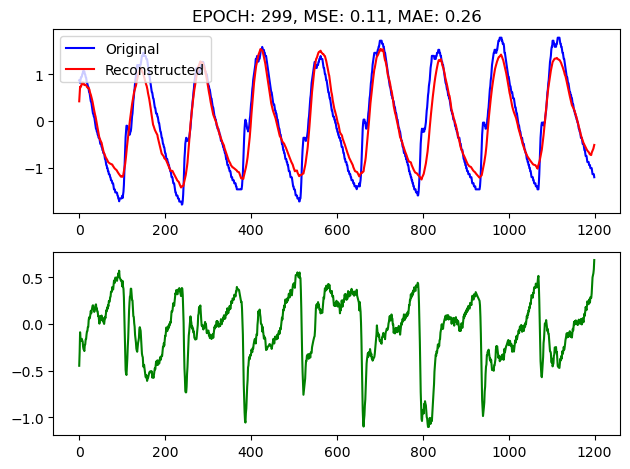

In [21]:
model_name = 'icp_artf_sanity_check_50pt'
logger = WandbLogger(project='test_proj', config=None, name=model_name)
model = VAE(input_shape=1200, latent_dim=20)
model = train(model, 'cuda', 
              train_data, train_data, val_data, val_data,
              lr=0.001, batch_size=256, num_epoch=300, use_tqdm=True, special_case='VAE', 
              logger=logger, epoch_per_validate=2)
posttrain(model, f'{model_name}.pth')


In [25]:
icp_val_numpy = np.load('data/data_icp_val_0216_500000.npy')
# shuffle the data
np.random.shuffle(icp_val_numpy)
rprint(icp_val_numpy.shape)

(5000, 1, 1200)

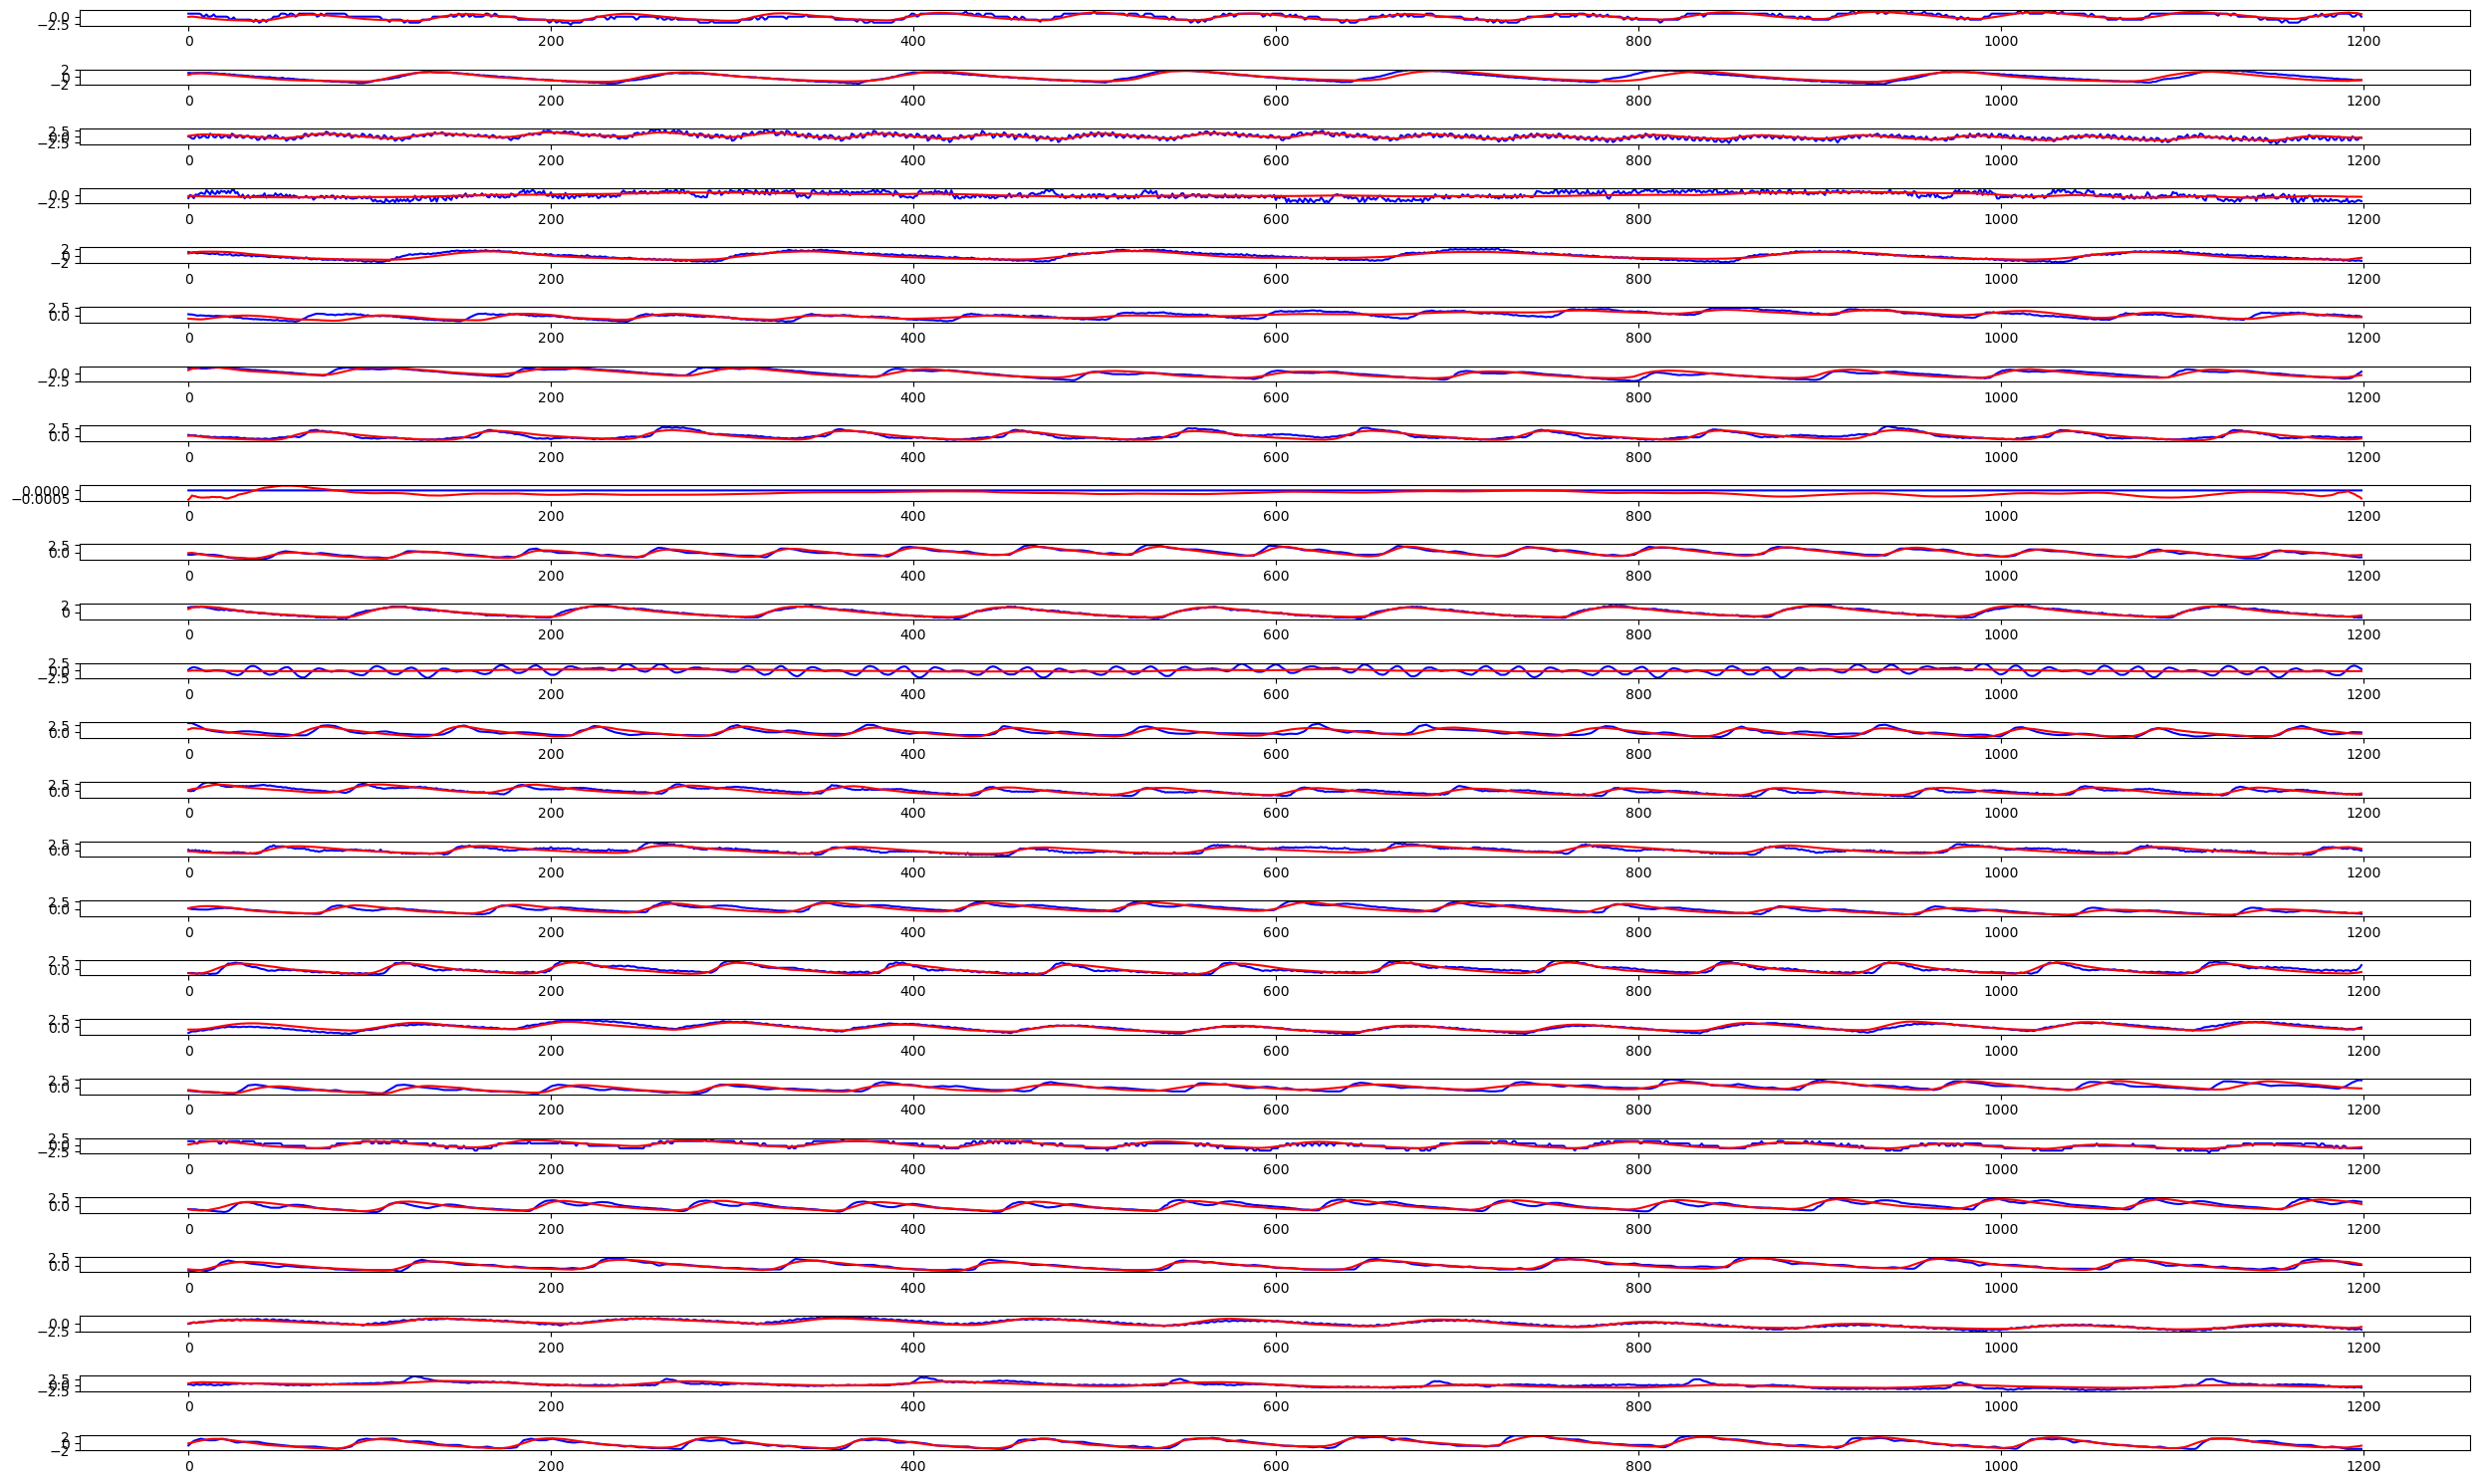

In [26]:
ckpt_path = 'icp_artf_sanity_check_50pt.pth'
plot_validation(ckpt_path, icp_val_numpy[:25])

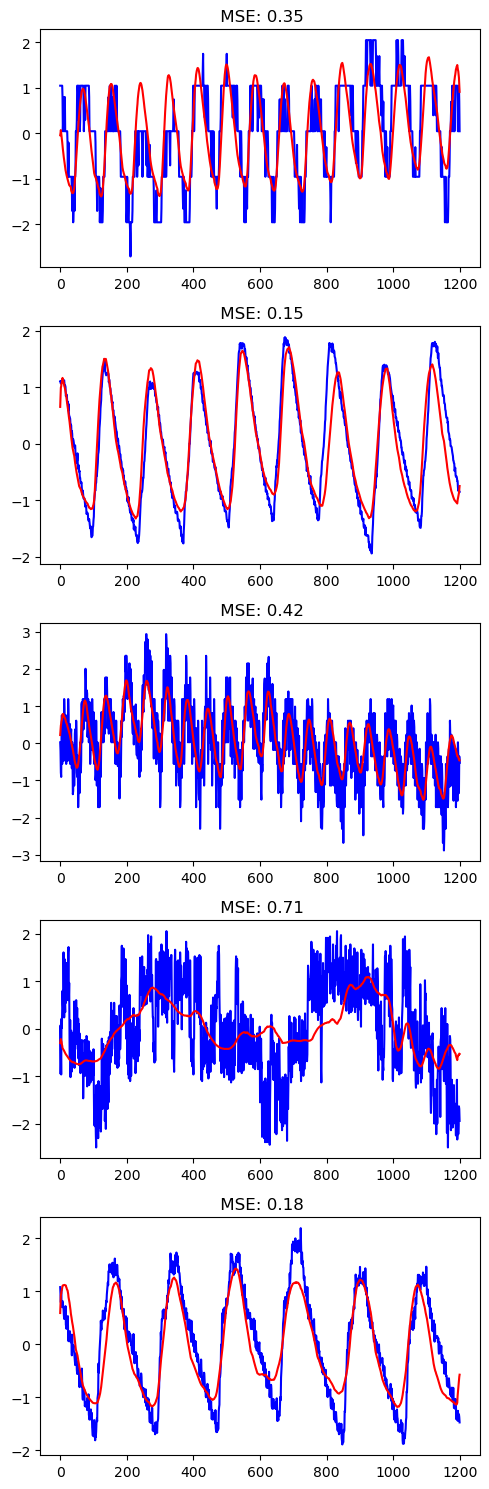

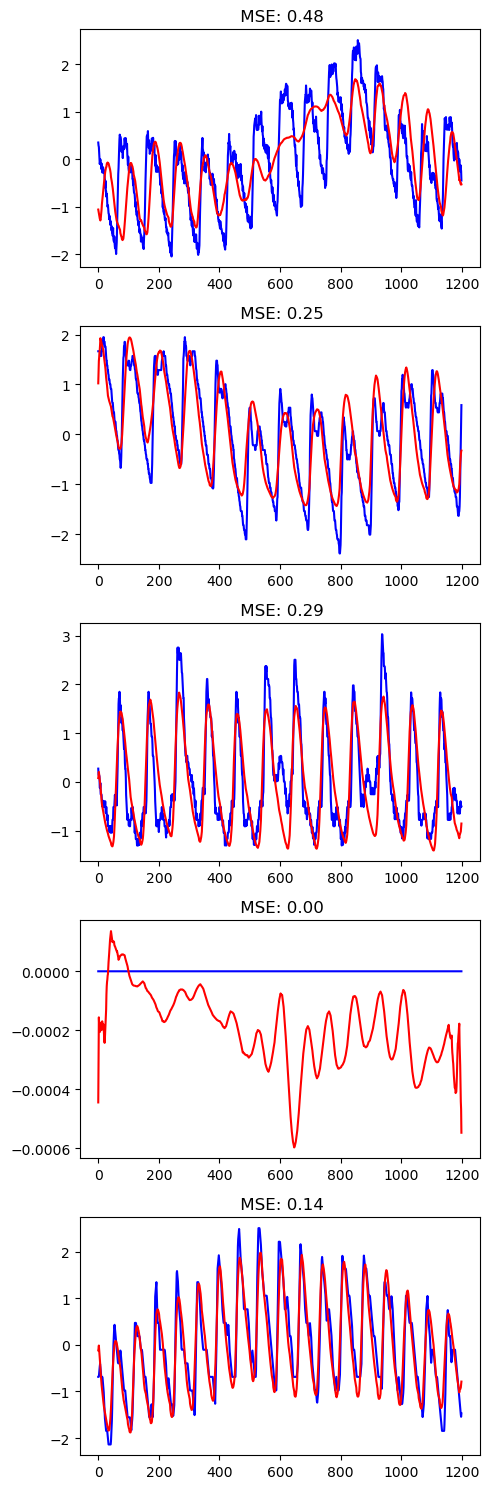

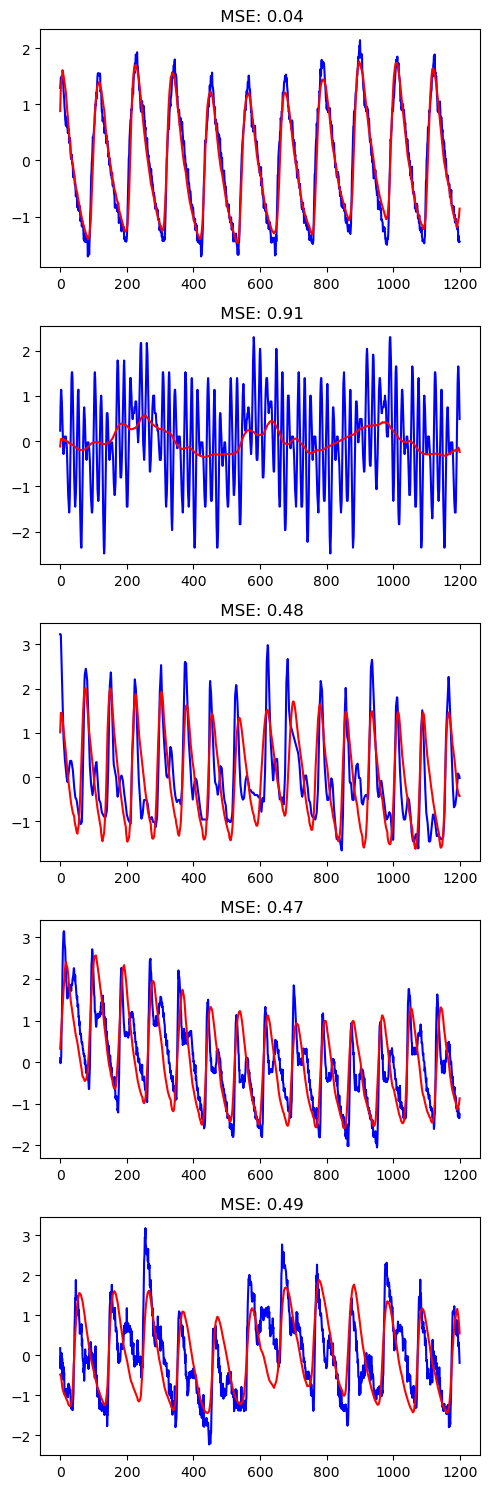

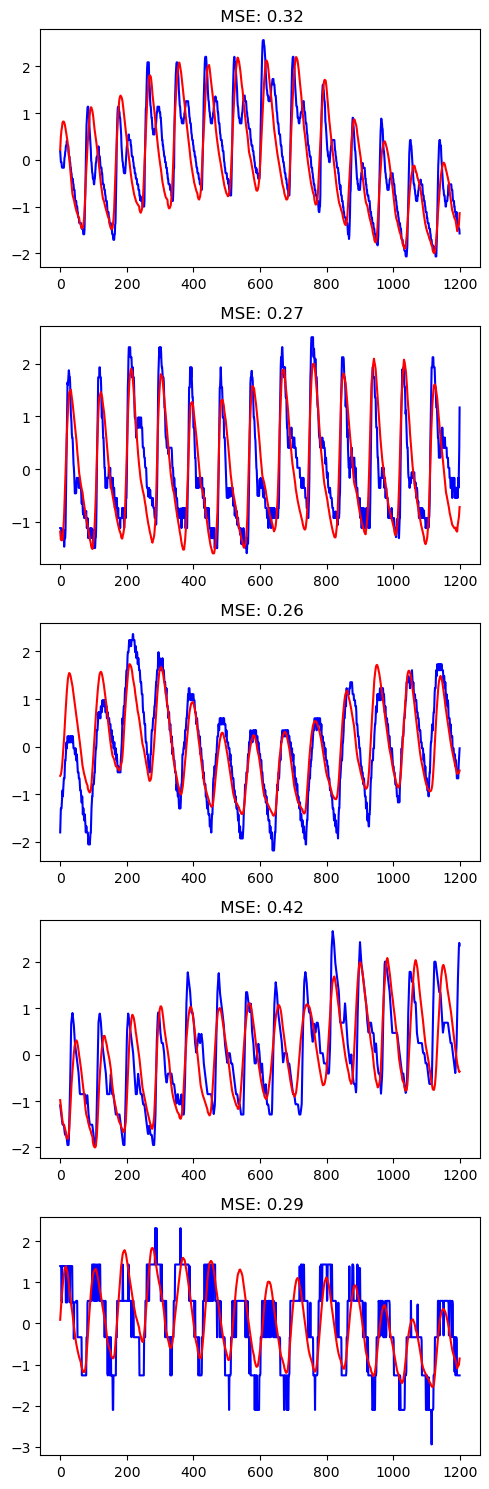

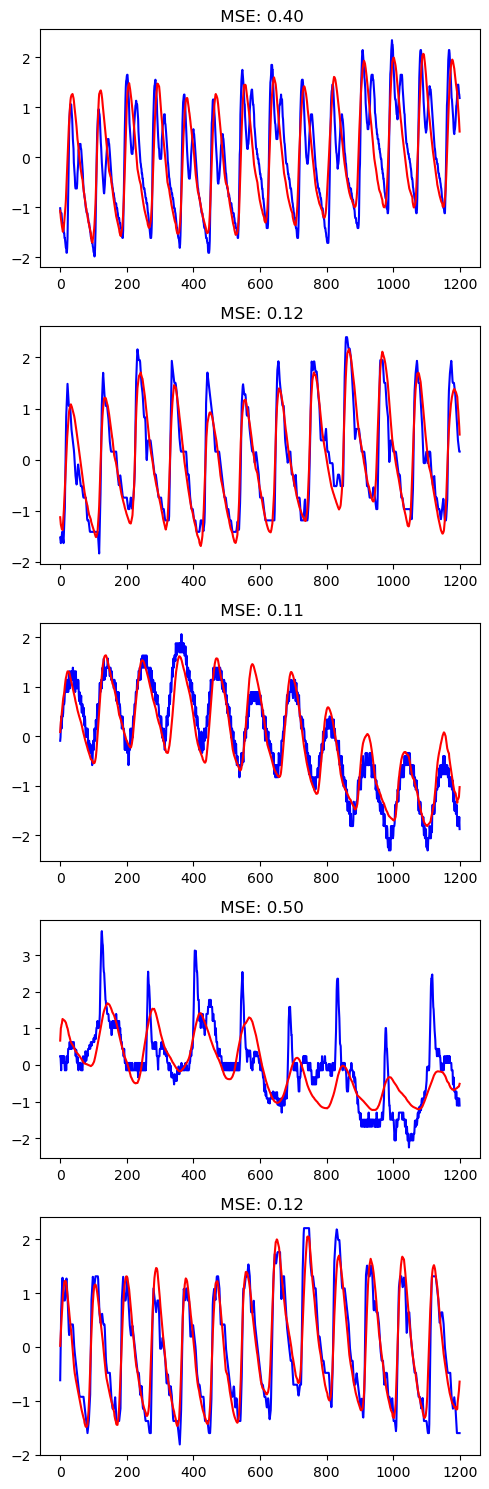

In [53]:
for i in range(0, 25, 5):
    plot_validation(ckpt_path, icp_val_numpy[i:i+5])

In [30]:
validation_outputs = get_evaluate_outputs(ckpt_path, icp_val_numpy)

In [37]:
outputs = np.array([validation_outputs[i][0][0] for i in range(len(validation_outputs))])
rprint(outputs.shape)

(5000, 1, 1200)

(5000,)

(array([ 81., 130., 345., 398., 348., 360., 365., 292., 275., 249., 208.,
        193., 169., 160., 178., 153., 128., 131., 106.,  89.,  78.,  71.,
         48.,  57.,  33.,  31.,  35.,  33.,  24.,  22.,  22.,  17.,   9.,
         19.,  16.,  18.,  22.,  20.,  25.,  29.,   3.,   2.,   2.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.]),
 array([4.11083570e-08, 2.53238353e-02, 5.06476294e-02, 7.59714236e-02,
        1.01295218e-01, 1.26619012e-01, 1.51942806e-01, 1.77266600e-01,
        2.02590394e-01, 2.27914189e-01, 2.53237983e-01, 2.78561777e-01,
        3.03885571e-01, 3.29209365e-01, 3.54533159e-01, 3.79856954e-01,
        4.05180748e-01, 4.30504542e-01, 4.55828336e-01, 4.81152130e-01,
        5.06475924e-01, 5.31799719e-01, 5.57123513e-01, 5.82447307e-01,
        6.07771101e-01, 6.33094895e-01, 6.58418689e-01, 6.83742484e-01,
        7.09066278e-01, 7.34390072e-01, 7.59713866e-01, 7.85037660e-01,
        8.10361454e-01, 8.35685249e-01, 8.61009043e-01, 8.86332837e-01,
        9.

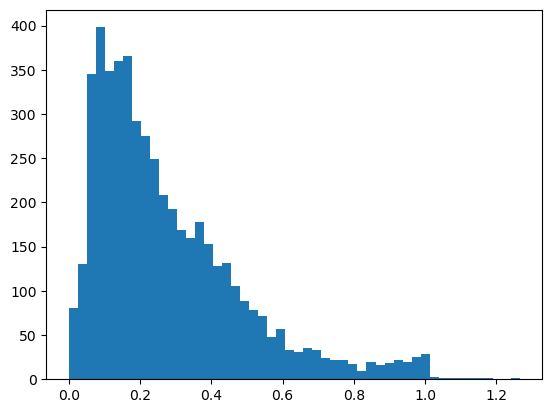

In [ ]:
# Example usage
value_array = instance_level_mse(icp_val_numpy, outputs)
rprint(value_array.shape)

# plot the distribution of mse values
plt.hist(value_array, bins=50)